<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from datetime import date

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
hoje = date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [ ]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
os.listdir(baseDIR)

In [4]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [67]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek

    dataset["Carga_Var"] = dataset["Carga"].pct_change()
    dataset["Temp_Var"] = dataset["Temperatura"].pct_change()

    dataset["Carga D-1"] = dataset["Carga"].shift(1, axis = 0)
    dataset = dataset.iloc[1:]

    correlation = dataset["Carga"].corr(dataset["Temperatura"])

    return dataset, correlation

def baseNormalizer(dataset, normalizer, normalize_fit = True):
    
    normalizadorCarga = normalizer
    normalizadorTemp = normalizer

    if normalize_fit:
        dataset[["Carga"]] = normalizadorCarga.fit_transform(dataset[["Carga"]])
        dataset[["Carga D-1"]] = normalizadorCarga.transform(dataset[["Carga D-1"]])
        dataset[["Temperatura"]] = normalizadorTemp.fit_transform(dataset[["Temperatura"]])

    dummies = pd.get_dummies(dataset["Weekday"],prefix="Dia")
    dataset = dataset.join(dummies)
    dataset = dataset.drop(["Date","Weekday"], axis = 1 )
    dataset = dataset.dropna()

    return dataset , normalizadorCarga, normalizadorTemp

In [73]:
historico, correlation = basePreprocessing(historicoCarga,historicoTemperatura)
historico, normalizadorCarga, normalizadorTemp = baseNormalizer(historico,StandardScaler())
historico = historico.dropna()

cols = [  
    'Year',
    'Month',
    'Day',
    'Hora',
    'Carga',
    'Carga D-1',
    'Temperatura',
    'Carga_Var',
    'Temp_Var',
    'Dia_0',
    'Dia_1',
    'Dia_2',
    'Dia_3',
    'Dia_4',
    'Dia_5',
    'Dia_6']

historico = historico[cols]
base = historico.values
historico

,Year,Month,Day,Hora,Carga,Carga D-1,Temperatura,Carga_Var,Temp_Var,Dia_0,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6
1,2014,1,1,2,-0.857916,-0.822059,0.118757,-0.006480,-0.004787,0,0,1,0,0,0,0
2,2014,1,1,3,-0.967533,-0.857916,-0.051350,-0.019939,-0.027436,0,0,1,0,0,0,0
3,2014,1,1,4,-1.135679,-0.967533,-0.051350,-0.031208,0.000000,0,0,1,0,0,0,0
4,2014,1,1,5,-1.262884,-1.135679,-0.076120,-0.024370,-0.004108,0,0,1,0,0,0,0
5,2014,1,1,6,-1.341795,-1.262884,-0.154476,-0.015495,-0.013048,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61986,2021,1,26,19,1.492468,1.737552,0.904586,-0.030283,-0.044790,0,1,0,0,0,0,0
61987,2021,1,26,20,2.005166,1.492468,0.560581,0.065329,-0.049242,0,1,0,0,0,0,0
61988,2021,1,26,21,2.099413,2.005166,0.477423,0.011273,-0.012520,0,1,0,0,0,0,0
61989,2021,1,26,22,2.069162,2.099413,0.365703,-0.003578,-0.017033,0,1,0,0,0,0,0


In [74]:
print(f"A correlação é {round(correlation,4)}")

A correlação é 0.6494


In [ ]:
plt.figure(figsize=(15, 8))
axes = plt.gca()
axes.set_xlim(0,720)

plt.plot(historico["Temperatura"])
plt.plot(historico["Carga"])

In [113]:
Xdataset = historico[['Carga D-1','Temperatura','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6']]
Ydataset = historico[['Carga']]
base_X = Xdataset.values
base_Y = Ydataset.values

dias= 30

print(f'Tamanho original da base X = {base_X.shape}, Y = {base_Y.shape}')

split_time = base_X.shape[0] - (24*dias)

x_train = base_X[:split_time]
y_train = base_Y[:split_time]

x_valid = base_X[split_time:]
y_valid = base_Y[split_time:]

print(f'formato dados de treino X = {x_train.shape}, Y = {y_train.shape}')
print(f'formato dados de teste X = {x_valid.shape}, Y = {y_valid.shape}')

Tamanho original da base X = (61983, 8), Y = (61983, 1)
formato dados de treino X = (61263, 8), Y = (61263, 1)
formato dados de teste X = (720, 8), Y = (720, 1)


In [9]:
diasAnteriores = 30*24

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [97]:
window_size = 24*diasAnteriores
batch_size = 32
shuffle_buffer_size = 1000

In [103]:
train_set = windowed_dataset(x_train, diasAnteriores,batch_size,shuffle_buffer_size)
print(train_set)

<PrefetchDataset shapes: ((None, None, 8, 1), (None, None, 8, 1)), types: (tf.float64, tf.float64)>


In [ ]:
def createModel():
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True,input_shape = (previsores.shape[1],9)))
    model.add(Dropout(0.5))

    # model.add(LSTM(units = 50, return_sequences = True))
    # model.add(Dropout(0.3))

    model.add(LSTM(units = 30))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1, activation= "linear"))

    model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

    return model

In [ ]:
es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath=f"pesos-{hoje}.h5", monitor = "loss", save_best_only = True, verbose=1)

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(previsores, valorReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

# Teste e Validação


In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-10.h5') # carrega modelo pré-treinado (OPCIONAL)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [ ]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoTeste = basePreprocessing(historicoCargaTeste, historicoTemperaturaTeste)

historicoTeste, _ , _ = baseNormalizer(historicoTeste,
                                        StandardScaler(),
                                        normalize_fit=True)

valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

In [ ]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])
historicoTeste

In [ ]:
entradas = historicoTeste.values
entradas.shape

(62753, 13)

In [ ]:
X_teste = []
Y_teste = []
for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,4]
    cargaVerificada = entradas[i,4]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,5]
    vetorDiaSemana = entradas[(i+1 - diasAnteriores):i+1,6:]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste,vetorDiaSemana))

    X_teste.append(batchTeste)
    Y_teste.append(cargaVerificada)
    
X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)
print(X_teste.shape)
print(Y_teste.shape)

In [ ]:
previsoes = model.predict(X_teste)

In [ ]:
previsoes = normalizadorCarga.inverse_transform(previsoes)
previsores

In [ ]:
loss = tf.keras.losses.mean_absolute_percentage_error(Y_teste, previsoes[:,0]).numpy()
loss

156.34515

In [ ]:
previsoes

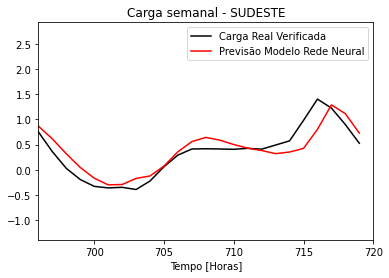

In [ ]:
axes = plt.gca()
axes.set_xlim(696,720)
plt.plot(Y_teste[:], color = "black", label = "Carga Real Verificada")
plt.plot(previsoes[:], color = "red", label = "Previsão Modelo Rede Neural")
plt.title("Carga semanal - SUDESTE")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()